In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (16.0, 8.0), 'axes.grid': True,
             'lines.markersize': 12, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
from matplotlib import cm

### a)

In [2]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

In [3]:
def matrix_tridiag(B, A, C, N):
    #Returns a matrix tridiag of square matrices B, A and C (tridiag(B,A,C), of size d * d, of size Nd * Nd
    d = np.shape(A)[0] 
    T = np.zeros((d*N, d*N))
    
    for i in range(0, d*N, d):
        T[i:i+d, i:i+d] = A
        
    for i in range(0, d*(N-1), d):
        T[i:i+d, i+d:i+2*d] = C
        T[i+d:i+2*d, i:i+d] = B
    
    return T

In [4]:
def anisotropic_solver(g, f, a, M, r=2, irr = False):
    """
    Solves the stationary heat equation in an anisotropic material on the domain [0,1] x [0,2],
    with heat flow in directions d_1=(1,0) and d_2=(1,r), for a general (possibly irrational) r, with relative
    thermal conductivity kappa_1/kappa_2 = a, using an alternative scheme along the top row.
    M is the number of grid intervals in x and y direction.
    g(x, y) is the dirichlet boundary conditions.
    f(x, y) is internal heat source.
    r is the relative flow in y direction for d_2.
    Returns U in matrix form.
    """
    h_x = 1 / M
    h_y = abs(r) * h_x
    
    N = int(np.ceil(2*M // abs(r))) #Number of grid intervals in y-direction.
    #Last grid length in y_direction. Used in alternative scheme.
    k = 2 % h_y
    #Used for alternative scheme: ratio of directional midpoint for last step and others.
    eta = np.sqrt((1 + k ** 2) / (1 + h_y ** 2))
    
    # inserting initial values
    grid_x = h_x * np.arange(M+1)
    grid_y = h_y * np.arange(N+1)
    
    x,y = np.meshgrid(grid_x, grid_y)
    #Initialising U with the initial value evaluated on the grid
    #Inverting to order the meshgrid points in the natural matrix order
    U = g(x,y)[::-1,:]
    
    #Generating b-vector
    b = np.zeros((M - 1) * (N - 1))

    #Adding boundary conditions due to the upper boundary for the top/bottom row of our grid
    #Grid point U along top-row depend on boundary point U + (h_x, h_y). Here with values for alternative scheme.
    if irr:
        b[:M-1] = U[0,2:] * (2 / (eta ** 2 + eta))
    else:
        b[:M-1] = U[0,2:]
    
    #Grid point U along bottom-row depend on boundary point U - (h_x, h_y)
    b[-(M-1):] = U[-1,:-2]
    
    
    #Adding boundary conditions for the left/rightmost column in the diagonal direction
    #Grid point U along leftmost column depend on B. points U - a(h_x, 0) and U -(h_x, h_y)
    b[::M-1] += a*U[1:-1,0] + U[2:,0]
    #For the rightmost column we have to use a different expression, as we already have treated the top row
    #Grid point U along along rightmost column depend on U + a(h_x, 0) and U +(h_x, h_y)
    b[M-2::M-1] += a*U[1:-1,-1]
    b[2*(M-1)-1::M-1] += U[1:-2,-1]


    #Generating f-vector
    #Inverting to order the meshgrid points in the natural matrix order
    try:
        f_vec = f(x,y)[::-1,:]
    except:
        f_vec = f(x,y,r,a)[::-1,:]
        
    #Keeping the interior points, as the boundary is fixed
    f_vec = np.reshape(f_vec[1:-1,1:-1], (M-1) * (N-1))
    
    
    #Generating matrix for linear system
    
    C = tridiag(-a, 2*(a+1), -a, M-1)
    L = tridiag(0, 0, -1, M-1)
    T = tridiag(-1, 0, 0, M-1)
    
    A_h = matrix_tridiag(L, C, T, N-1)
    
    if irr:
        A_h[0:(M-1), 0:(M-1)] = tridiag(-a, 2*(a + 1/eta), -a, M-1)
        A_h[0:(M-1), (M-1):2*(M-1)] = tridiag(-2/ (eta + 1), 0, 0, M-1)
    else:
        A_h[0:(M-1), 0:(M-1)] = tridiag(-a, 2*(a + 1), -a, M-1)
        A_h[0:(M-1), (M-1):2*(M-1)] = tridiag(-1, 0, 0, M-1)

    #Solving linear system
    U[1:-1,1:-1] = np.reshape(np.linalg.solve(A_h / (h_x ** 2), f_vec + b / (h_x ** 2)),(N-1,M-1))
    
    #We invert and transpose U to rotate it in the plots
    return grid_x,grid_y,U[::-1,:].T

In [7]:
def plot_solution(x, y, U, txt='Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    Y,X = np.meshgrid(y,x)
    ax.plot_surface(Y, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('y')
    plt.ylabel('x')
    plt.title(txt)
    
def plot_heatmap(x, y, U, txt='Heatmap'):
    plt.rcParams['axes.grid'] = False
    fig, ax = plt.subplots()
    Y,X = np.meshgrid(y,x)
    mesh = ax.pcolormesh(X,Y,U,shading="gouraud")
    fig.colorbar(mesh)
    plt.title(txt)
    plt.rcParams['axes.grid'] = True

In [8]:
def f(x,y):
    return 5*np.exp(-(x- 0.5) **2 - (y-1) ** 2)

def g(x,y):
    return np.cos(x*np.pi/2)*np.sin(y*np.pi/2)

def f2(x,y):
    return 10*np.exp(-(x- 0.5) **2 - (y-1) ** 2)

In [9]:
def u1(x,y):
    return np.cos(x*np.pi)*np.sin(y*np.pi/2)

def u_f1(x,y,r,a):
    return np.pi**2*(np.cos(x*np.pi)*np.sin(y*np.pi/2)*((a+1)+(r/2)**2)+r*np.sin(x*np.pi)*np.cos(y*np.pi/2))

### c)

In [10]:
def convergence(u_exact, g, f, a, M, r=2, irr=False): 
    P = 4
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = M
    for p in range(P):
        x, y, U = anisotropic_solver(g, f, a, M, r, irr)
        Y,X = np.meshgrid(y,x)
        Eh = U-u_exact(X,Y)
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        print(Econv[p])
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order 

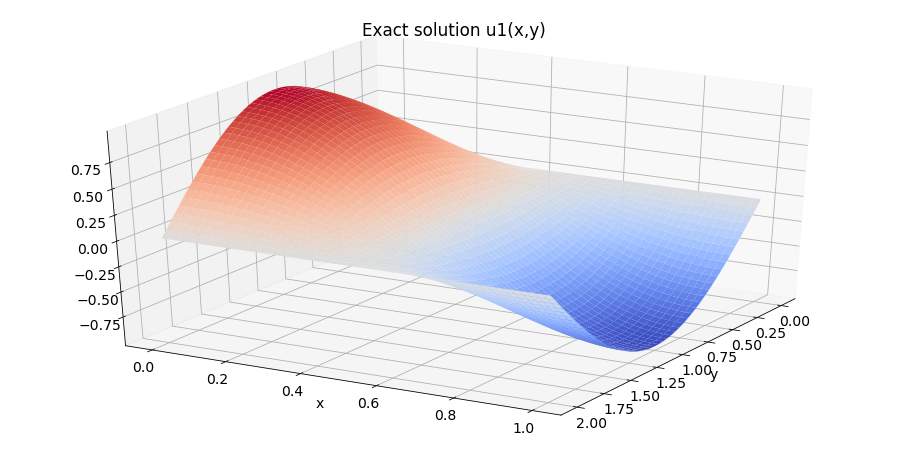

In [11]:
x,y = np.linspace(0,1,1000), np.linspace(0,2,1000)
Y,X = np.meshgrid(y,x)
plot_solution(x,y,u1(X,Y),txt='Exact solution u1(x,y)')
#plot_heatmap(x,y,u1(X,Y))

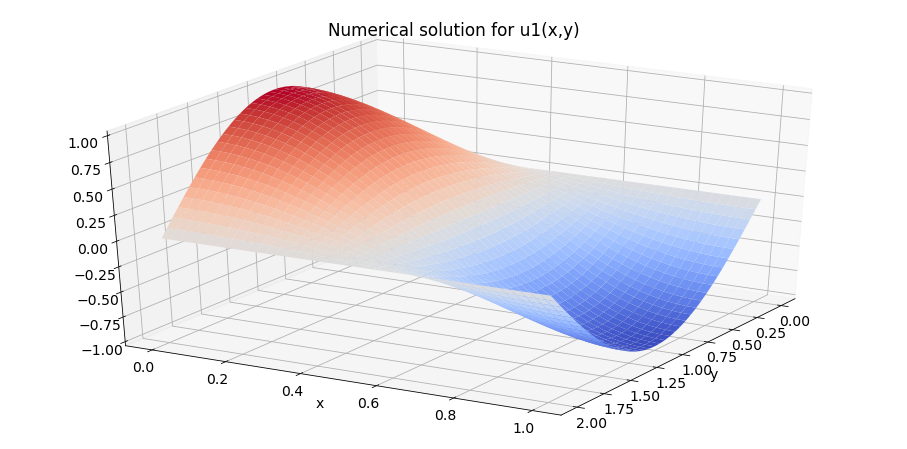

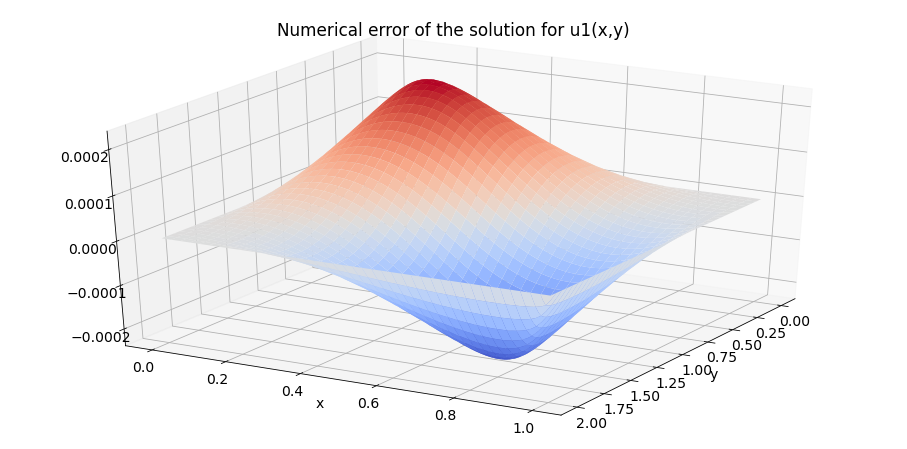

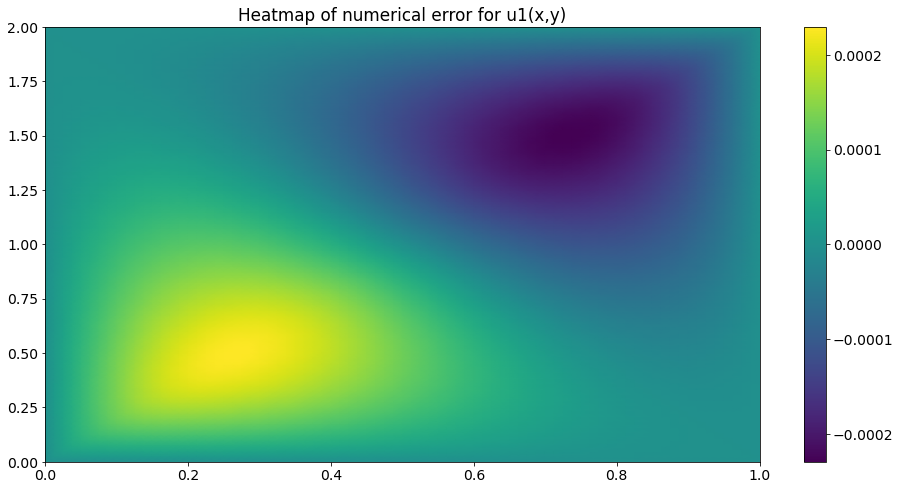

In [12]:
x,y,U = anisotropic_solver(u1, u_f1, 0.1, 80)
Y,X = np.meshgrid(y,x)

plot_solution(x,y,U,txt='Numerical solution for u1(x,y)')
plot_solution(x,y,U-u1(X,Y),txt='Numerical error of the solution for u1(x,y)')
#plot_heatmap(x,y,U)
plot_heatmap(x,y,U-u1(X,Y),txt='Heatmap of numerical error for u1(x,y)')

0.014605304818228693
0.003701416474403807
0.0009187878940568606
0.0002296540276023329


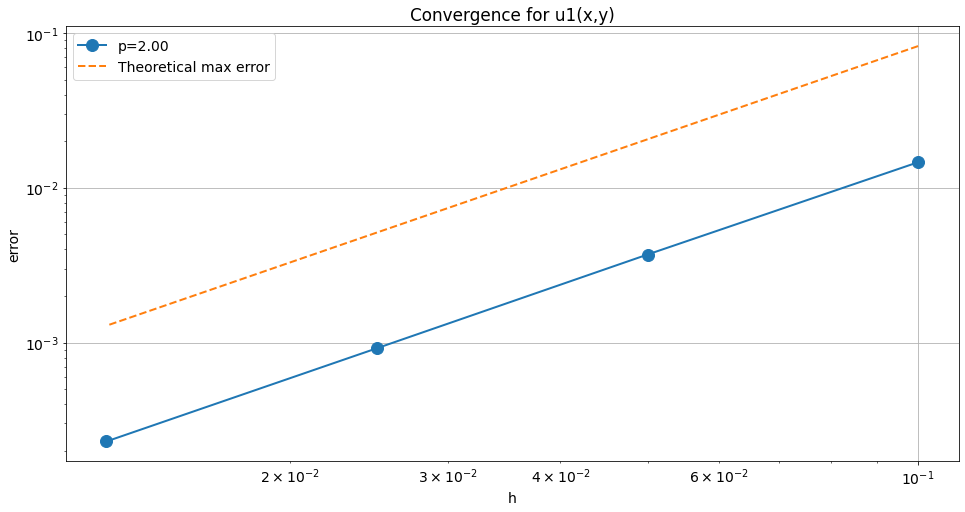

In [13]:
H, E, p = convergence(u1, u1, u_f1, 0.1, 10,r=2)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.loglog(H,(H**2/96)*np.pi**4*8.1,'--',label='Theoretical max error')
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('Convergence for u1(x,y)')
plt.legend();

In [14]:
def u2(x,y):
    return np.sin(x*np.pi)*y

def u_f2(x,y,r,a):
    return np.pi**2*np.sin(x*np.pi)*y*(a+1)-2*np.pi*r*np.cos(x*np.pi)

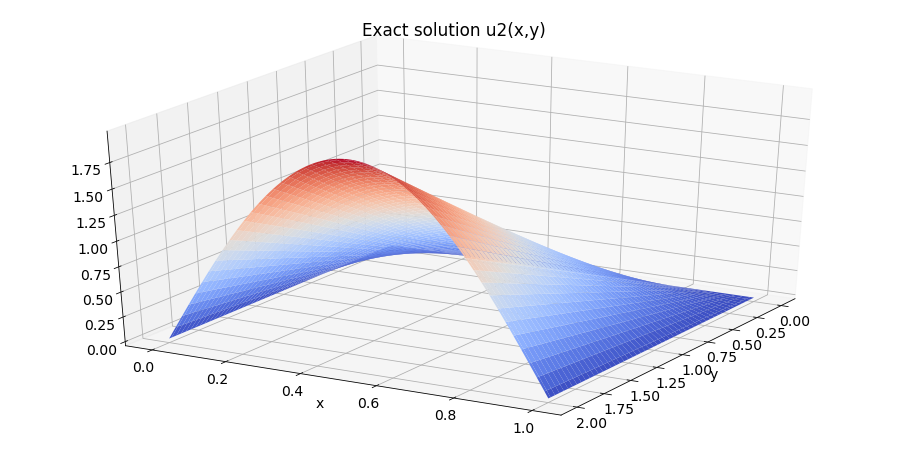

In [15]:
x,y = np.linspace(0,1,100), np.linspace(0,2,100)
Y,X = np.meshgrid(y,x)

plot_solution(x,y,u2(X,Y),txt='Exact solution u2(x,y)')
#plot_heatmap(x,y,u2(X,Y))

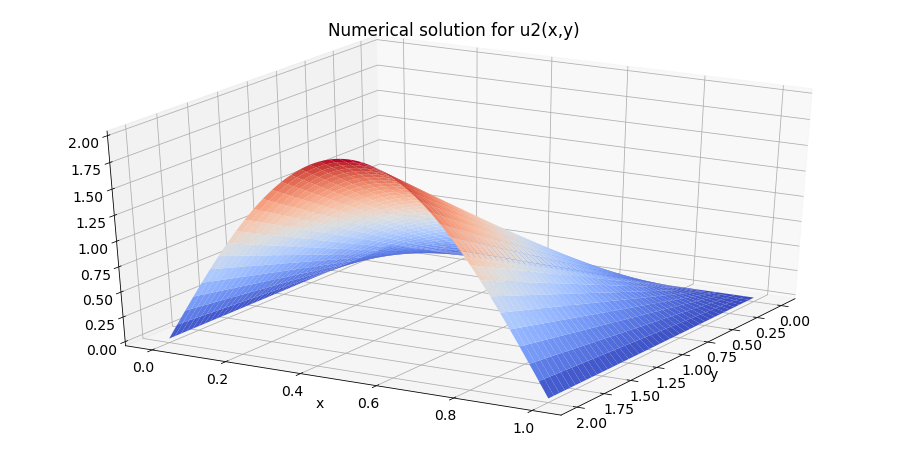

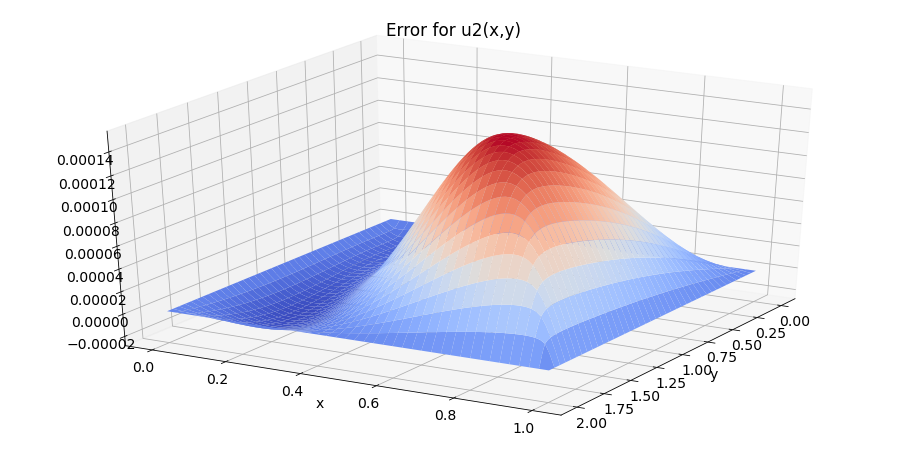

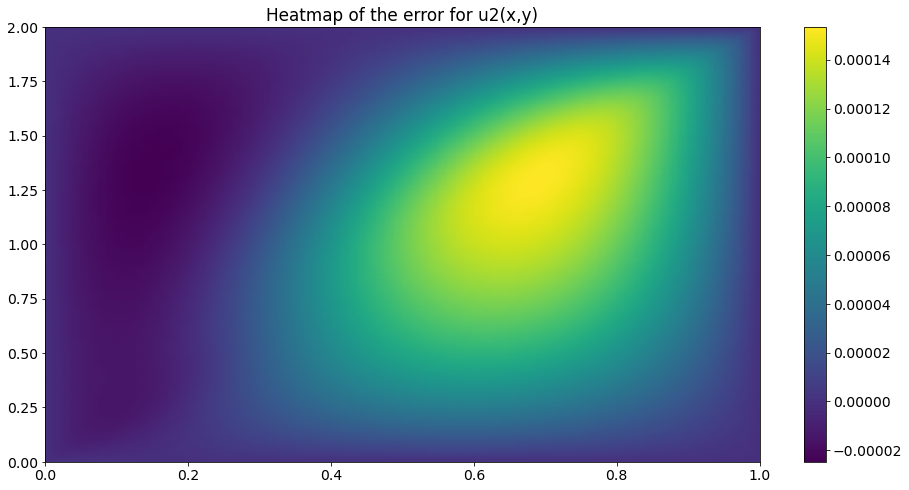

In [16]:
x,y,U = anisotropic_solver(u2, u_f2, 0.1, 80)
Y,X = np.meshgrid(y,x)
plot_solution(x,y,U,txt='Numerical solution for u2(x,y)')
#plot_heatmap(x,y,U)
plot_solution(x,y,U-u2(X,Y),txt='Error for u2(x,y)')
plot_heatmap(x,y,U-u2(X,Y),txt='Heatmap of the error for u2(x,y)')

0.009957274249219106
0.002462324575022823
0.0006134388323983941
0.0001534389306010464


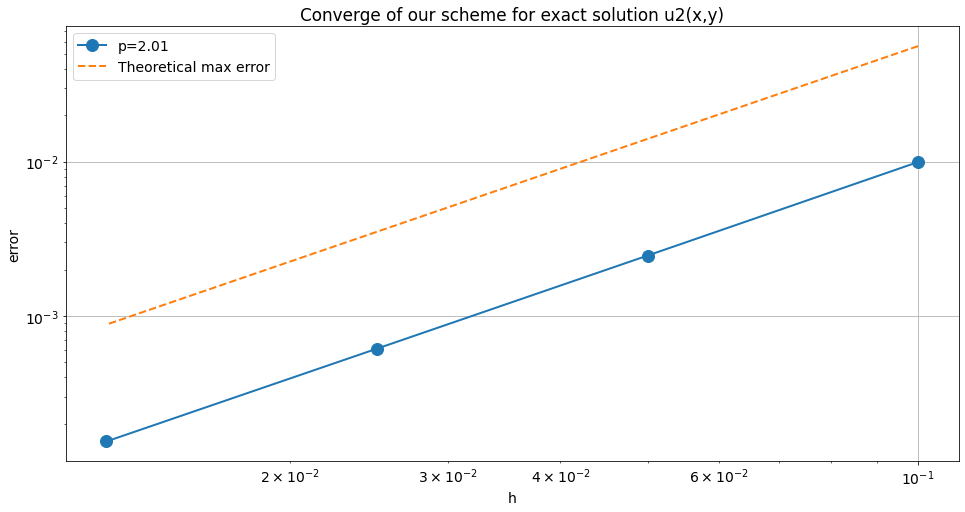

In [17]:
H, E, p = convergence(u2, u2, u_f2, 0.1, 10, r=2)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.loglog(H,(H**2/96)*540,'--',label='Theoretical max error')
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('Converge of our scheme for exact solution u2(x,y)')
plt.legend();

### d)

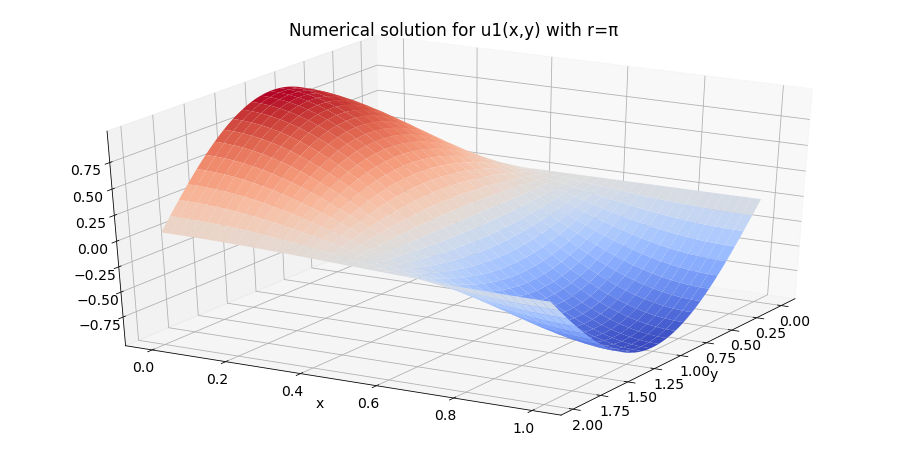

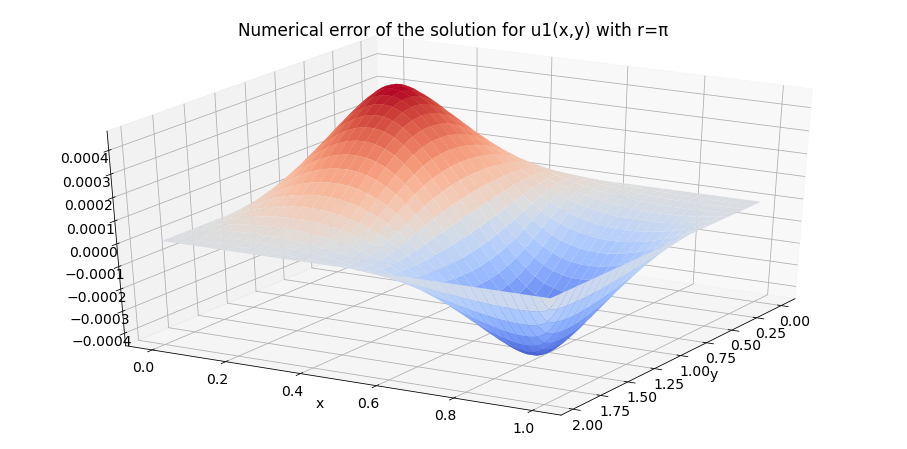

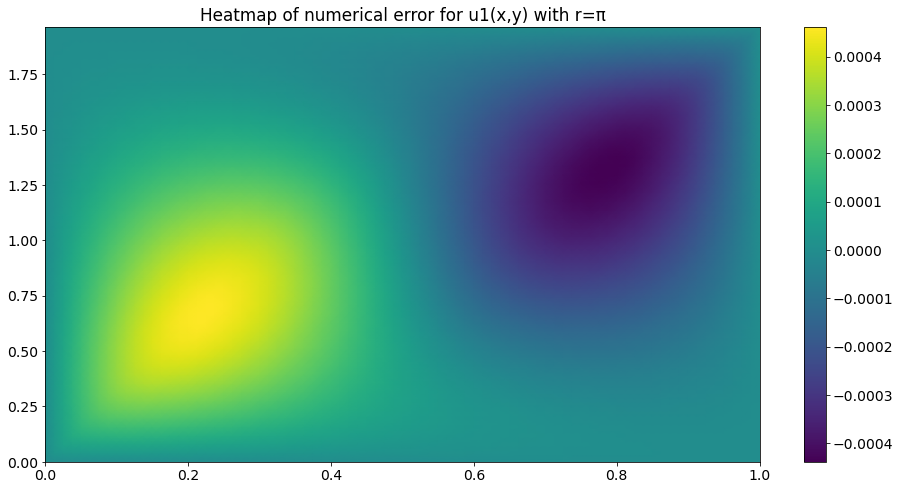

In [19]:
x,y,U = anisotropic_solver(u1, u_f1, 0.1, 80, np.pi)
Y,X = np.meshgrid(y,x)

plot_solution(x,y,U,txt='Numerical solution for u1(x,y) with r=π')
plot_solution(x,y,U-u1(X,Y),txt='Numerical error of the solution for u1(x,y) with r=π')
#plot_heatmap(x,y,U)
plot_heatmap(x,y,U-u1(X,Y),txt='Heatmap of numerical error for u1(x,y) with r=π')

0.03326340321999921
0.007773609570399742
0.0018821602146013028
0.0004622771201823195


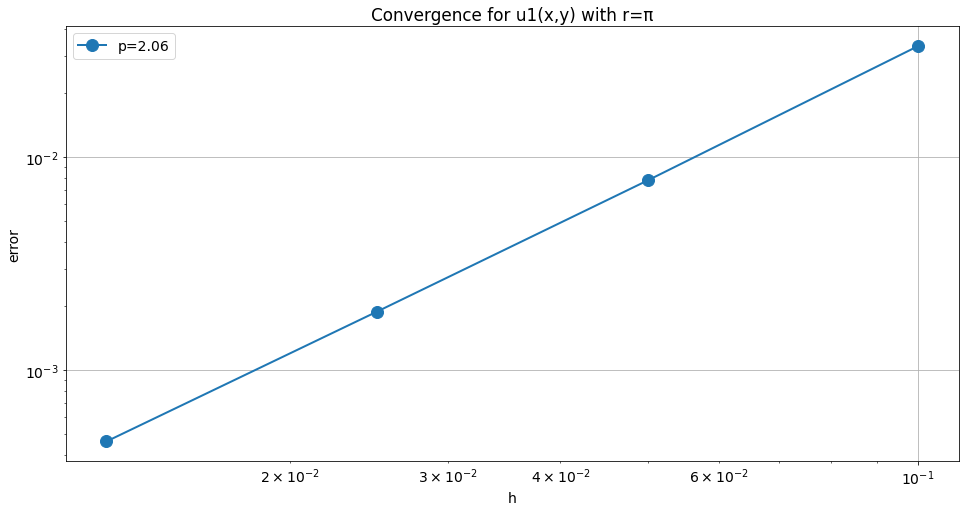

In [21]:
H, E, p = convergence(u1, u1, u_f1, 0.1, 10, r=np.pi, irr=True)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('Convergence for u1(x,y) with r=π')
plt.legend();
#Note error always about twice as large as in same case with r=2
#Ta med denne!

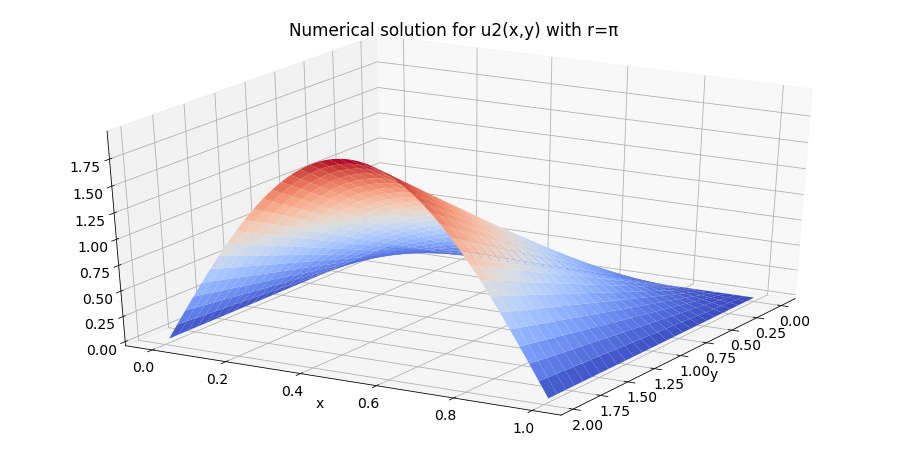

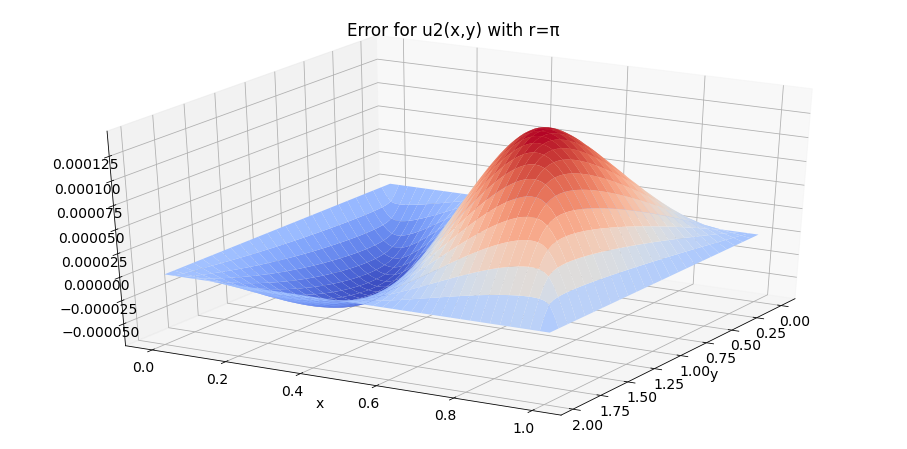

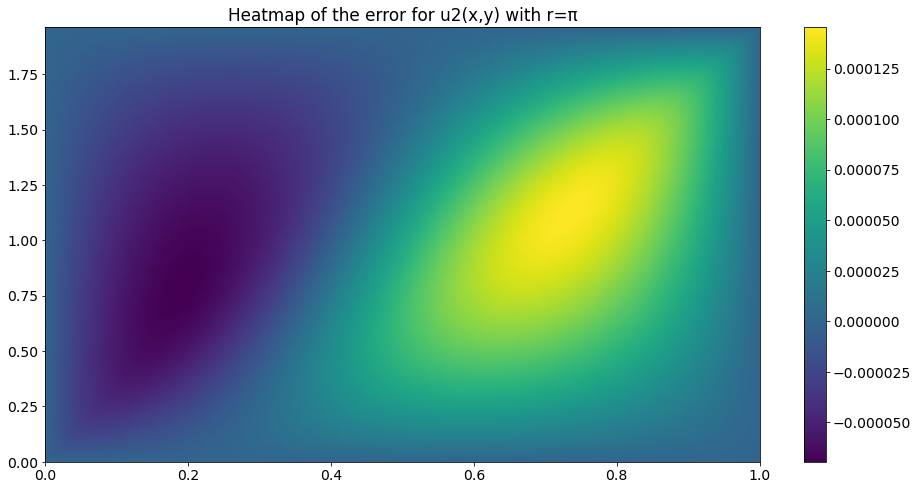

In [22]:
x,y,U = anisotropic_solver(u2, u_f2, 0.1, 80, np.pi)
Y,X = np.meshgrid(y,x)
plot_solution(x,y,U,txt='Numerical solution for u2(x,y) with r=π')
#plot_heatmap(x,y,U)
plot_solution(x,y,U-u2(X,Y),txt='Error for u2(x,y) with r=π')
plot_heatmap(x,y,U-u2(X,Y),txt='Heatmap of the error for u2(x,y) with r=π')

0.014550265891576708
0.0019146743274133238
0.0005201482226293574
0.00014374549120355073


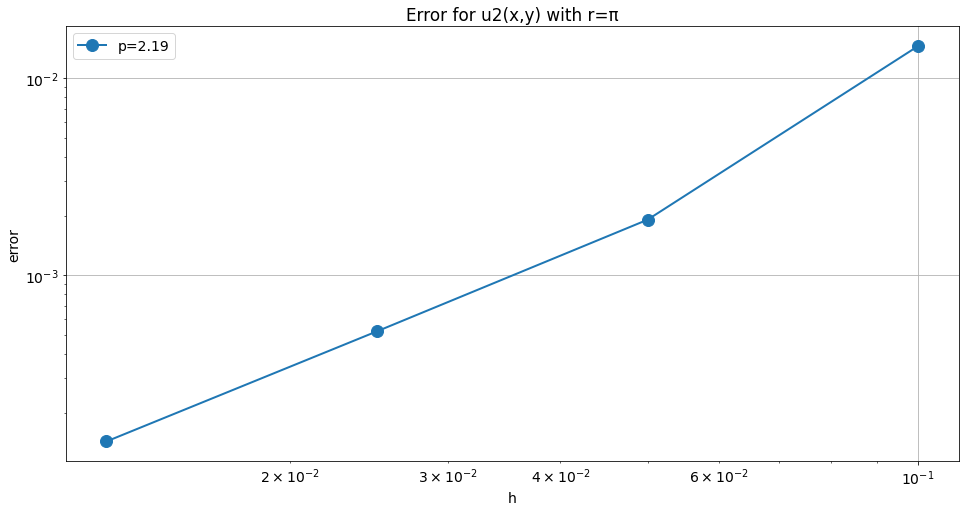

In [23]:
H, E, p = convergence(u2, u2, u_f2, 0.1, 10, r=np.pi, irr=True)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('Error for u2(x,y) with r=π')
plt.legend();
#Suprisingly lower error for smaller h despite fewer grid points in y-direction

# 2

### i) Modifying the scheme

In [29]:
def row_info(M):
    h = 1/M
    y_vals = h * np.arange(1, M)
    x_vals = np.sqrt(1 - y_vals)
    row_lengths = x_vals // h
    row_remains = x_vals % h
    return y_vals, x_vals, row_lengths.astype(int), row_remains

def in_domain(x,y):
    if y + x ** 2 - 1 < 0:
        return True
    return False

def alt_scheme(f, g, M):
    """Solves the stationary heat equation for the isotropic case, with the irregular domain in the positive quadrant
    enclosed by the parabola y = 1 - x^2, using alternative schemes for the grid points closest to the boundary. 
    f(x,y) is the internal heat source.
    g(x,y) is the Dirichlet boundary condition.
    M is the number of intervals in both directions, at the domains widest points.
    
    Returns U as a matrix.
    """
    h = 1/M
    
    
    #Extracting data about domain shape
    y_vals, x_vals, row_lengths, row_remains = row_info(M)
    total_points = sum(row_lengths)
    start_indexes = np.insert(np.cumsum(row_lengths).astype(int),0, 0)

    #Creating empty arrays to be filled in loops
    f_vec = np.zeros(total_points)
    b = np.zeros(total_points)

    A_h = np.zeros((total_points, total_points))
    
    for i in range(M-1):
 
        for j in range(row_lengths[i]):
            
            
            f_vec[start_indexes[i] + j] = f((j + 1) * h, y_vals[i])
            
            
            #x direction
            
            if j < row_lengths[i] - 1:  #If P is not next to boundary on right side: normal scheme.
                A_h[start_indexes[i] + j, start_indexes[i] + j] += 2
                A_h[start_indexes[i] + j, start_indexes[i] + j +1] = -1
                
                if j > 0:
                    A_h[start_indexes[i] + j, start_indexes[i] + j -1] = -1
                else:
                    b[start_indexes[i] + j] += g(0, y_vals[i])
                    
                    
            
            else:
                eta_x = x_vals[i] / h - (j + 1)
                A_h[start_indexes[i] + j, start_indexes[i] + j] += 2 / eta_x
                b[start_indexes[i] + j] += g(x_vals[i], y_vals[i]) * 2  / (eta_x * (eta_x +1))
                if j > 0:
                    A_h[start_indexes[i] + j, start_indexes[i] + j -1] = - (2  / (eta_x +1))
                else:
                    b[start_indexes[i] + j] += g(0, y_vals[i]) * (2  / (eta_x +1))
                    
                
                
            
            #y direction
            
            if in_domain((j+1) * h, y_vals[i] + h):
                A_h[start_indexes[i] + j, start_indexes[i] + j] += 2
                A_h[start_indexes[i] + j, start_indexes[i + 1] + j] = -1
                
                if i > 0:
                    A_h[start_indexes[i] + j, start_indexes[i - 1] + j] = -1
                else:
                    b[start_indexes[i] + j] += g((j+1) * h, 0)
                    
            else:
                eta_y = ((1 - ((j+1) * h) ** 2) - (i + 1) * h) / h
                A_h[start_indexes[i] + j, start_indexes[i] + j] += 2 / eta_y
                b[start_indexes[i] + j] += g((j + 1) * h, 1- ((j + 1) * h) ** 2) * 2  / (eta_y * (eta_y +1))
                if i > 0:
                    A_h[start_indexes[i] + j, start_indexes[i - 1] + j] = - (2  / (eta_y +1))
                else: 
                    b[start_indexes[i] + j] += g((j+1) * h, 0) * (2  / (eta_y +1))
                    
        
    U = np.linalg.solve(A_h / (h ** 2), f_vec + b / (h ** 2))
    
    ret = np.full((M-1, M-1), np.nan)
    MAX = h * np.arange(1, M)
    
    for i in range(M-1):
        for j in range(row_lengths[i]):
            ret[j, i] = U[start_indexes[i] + j]
        
    return MAX, y_vals, ret


In [30]:
def plot_solution2(x, y, U, txt='Solution'):
    # Plot the solution of the heat equation
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    Y,X = np.meshgrid(y,x)
    ax.plot_surface(Y, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=-60)              # Rotate the figure
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(txt)
    
def convergence2(u_exact, g, f, M, method):
    P = 4
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = M
    for p in range(P):
        x,y,sol =  method(f, g, M)
        Y,X = np.meshgrid(y,x)
        print(np.max(np.abs(np.nan_to_num(u_exact(X,Y)-sol))))
        Econv[p] = np.max(np.nan_to_num(np.abs(u_exact(X,Y)-sol)))
        Hconv[p] = (x[1]-x[0])
        
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order 

In [31]:
def u_f1_2(x,y):
    return np.pi**2*np.cos(x*np.pi)*np.sin(y*np.pi/2)*5/4


def u_f2_2(x,y):
    return np.pi**2*np.sin(x*np.pi)*y

def u4(x,y):
    return np.sin(x)*np.cos(y)

def u_f4(x,y):
    return 2*np.sin(x)*np.cos(y)

def u5(x, y):
    return np.exp(-(x-0.5)**2 - (y-0.5)**2)

def u_f5(x, y):
    return -np.exp(-(x-0.5)**2 - (y-0.5)**2)*(4*x**2 - 4*x + 4*y**2 - 4*y - 2)

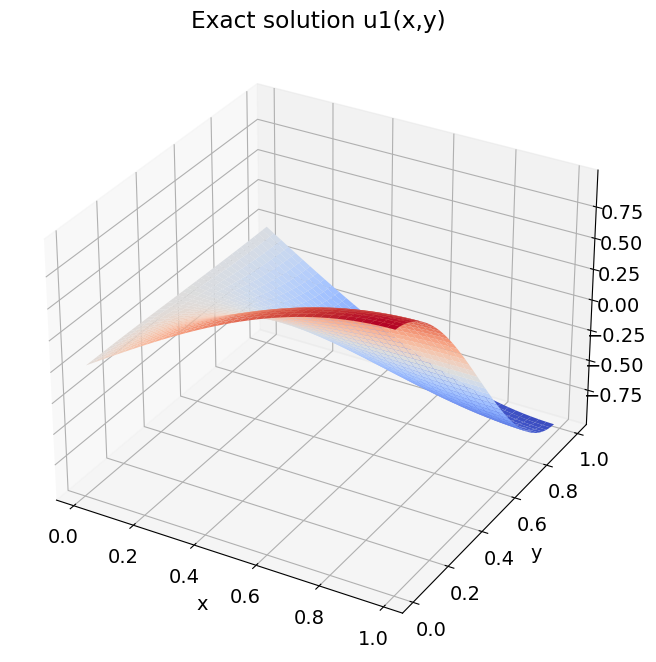

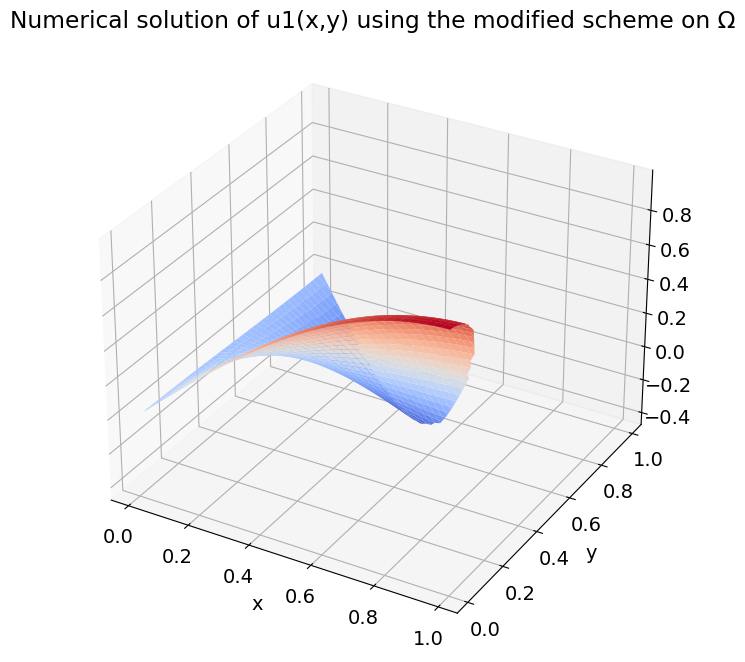

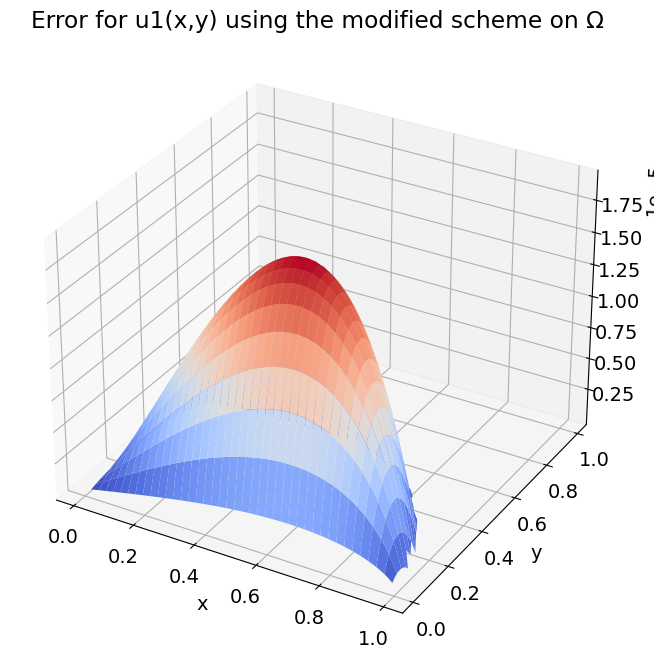

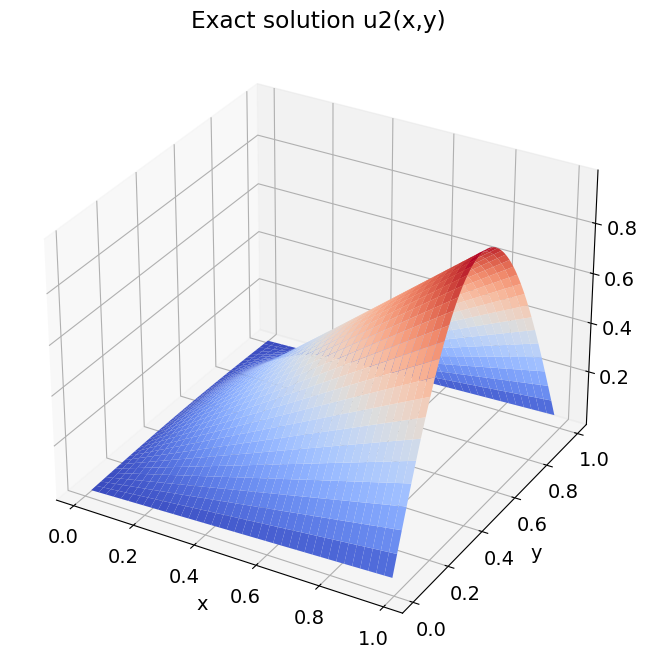

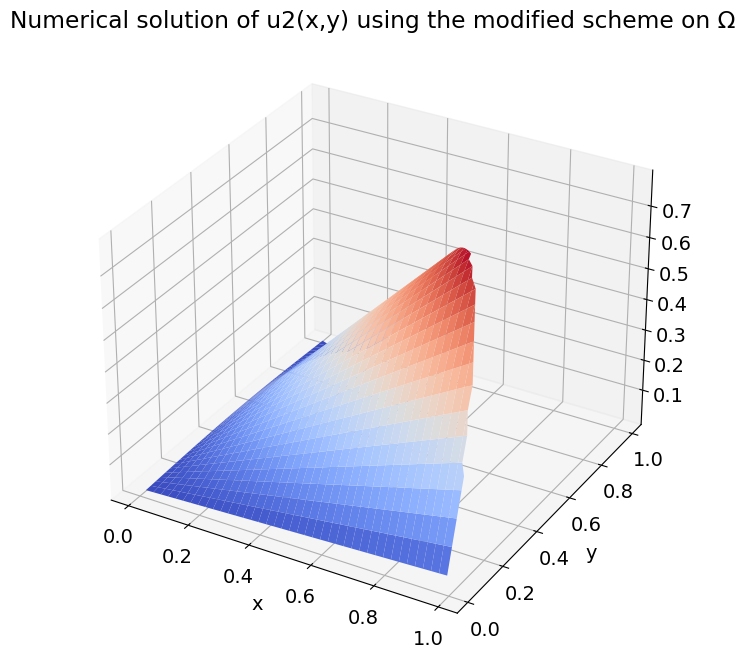

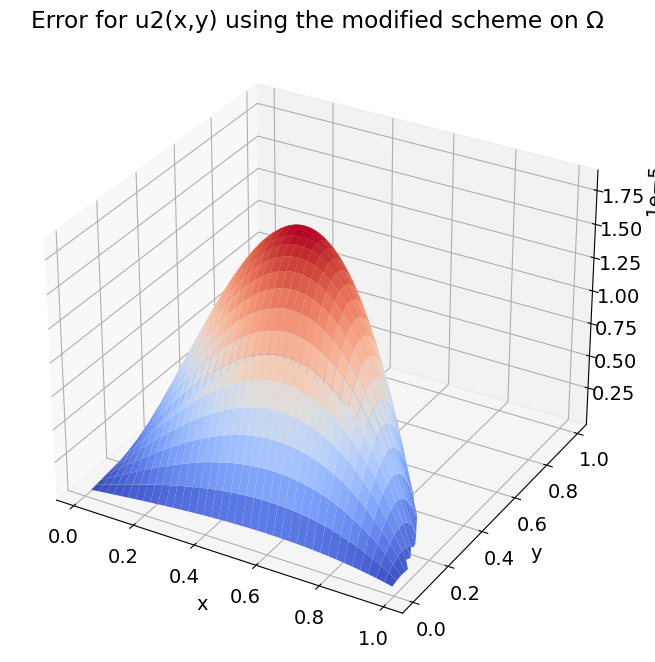

In [32]:
x, y, U = alt_scheme(u_f1_2, u1, 80)
Y,X = np.meshgrid(y,x)

plot_solution2(x,y,u1(X,Y), txt='Exact solution u1(x,y)')
plot_solution2(x,y,U,txt='Numerical solution of u1(x,y) using the modified scheme on Ω')

plot_solution2(x,y,np.abs(U-u1(X,Y)), txt='Error for u1(x,y) using the modified scheme on Ω')

x, y, U = alt_scheme(u_f2_2, u2,80)
Y,X = np.meshgrid(y,x)
plot_solution2(x,y,u2(X,Y),txt='Exact solution u2(x,y)')
plot_solution2(x,y,U,txt='Numerical solution of u2(x,y) using the modified scheme on Ω')
plot_solution2(x,y,(np.abs(U - u2(X,Y))),txt='Error for u2(x,y) using the modified scheme on Ω')


0.0010569253998766737
0.00029721742784594163
7.649997589864732e-05
1.9408699425293996e-05


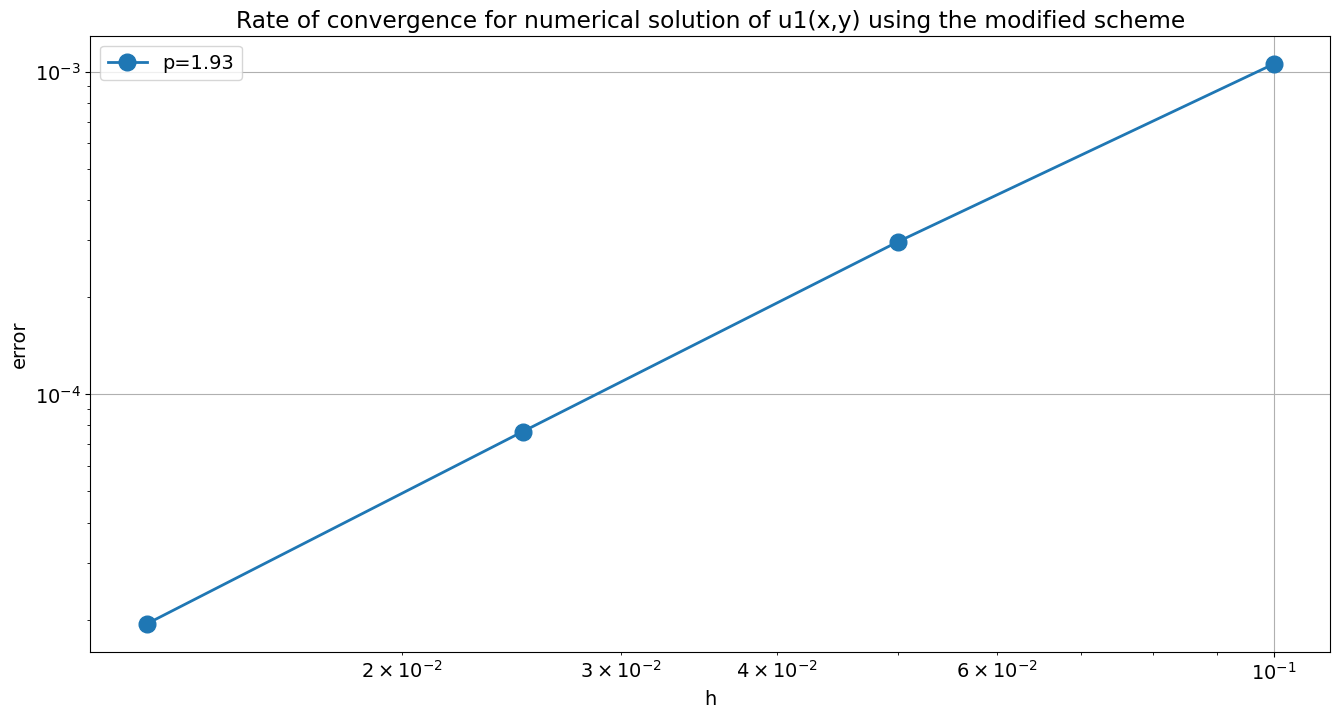

0.001152808935586891
0.0002936803707743185
7.402036343051588e-05
1.860688425692203e-05


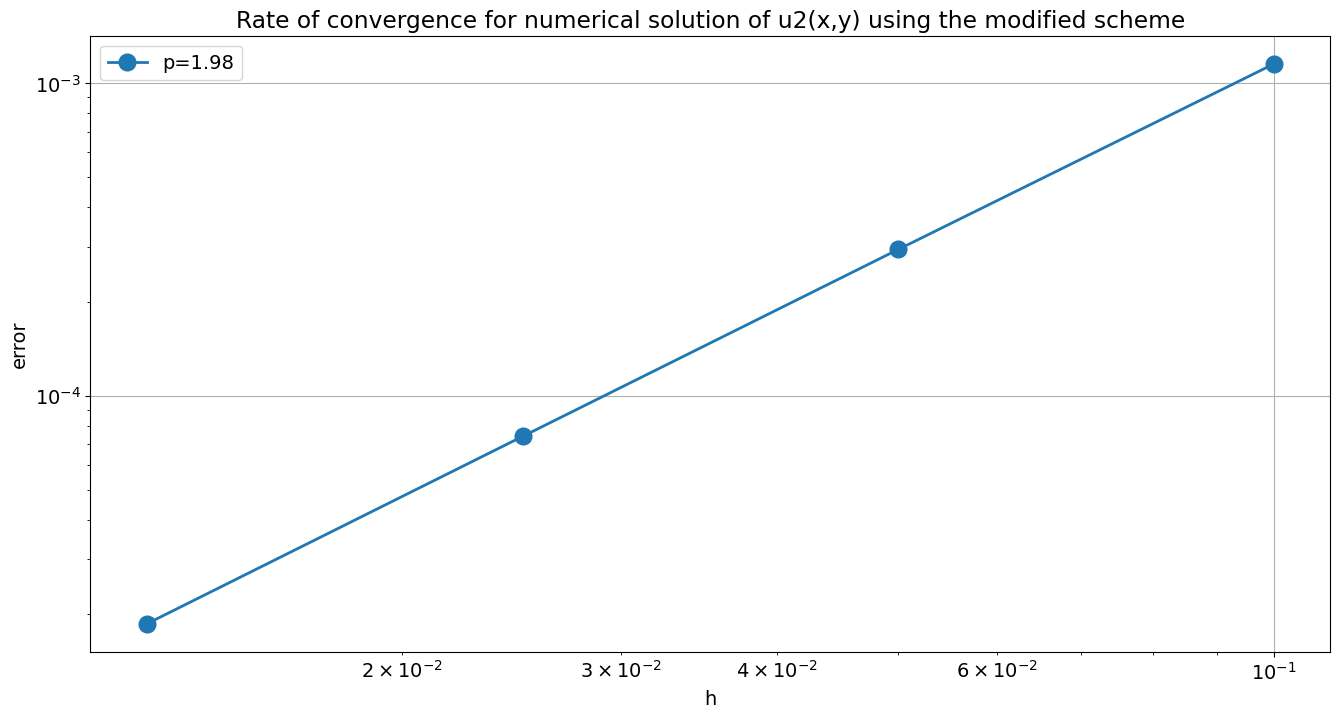

In [33]:
H, E, p = convergence2(u1, u1, u_f1_2, 10, alt_scheme)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('Rate of convergence for numerical solution of u1(x,y) using the modified scheme')
plt.legend();
plt.show()
H, E, p = convergence2(u2, u2, u_f2_2, 10, alt_scheme)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('Rate of convergence for numerical solution of u2(x,y) using the modified scheme')
plt.legend();

### ii) Fattening the boundary

In [34]:
def boundary_point(p):
    #array of coefficients of polynomial 
    pol = np.array([4, 0, 4*p[1]-2, -2*p[0]])
    #finding the roots of the polynomial 
    root = np.roots(pol)
    #finding the real-valued root
    x = root[np.isreal(root)].real[0]
    return [x, 1-x**2]

def row_lengths(M, r):
    h = 1/M
    N = int(np.ceil(1/(abs(r)*h)))
    k = abs(r)*h
    row_lengths = np.zeros(N-1)
    for i in range(1,N,1):
        j = 1
        while k*i-1+(h*j)**2<0:
            j+=1
        row_lengths[i-1]=j-1
    return row_lengths


def grid_for_plot(M,N,u, csum_row_len):
    sol = np.full((M, N),np.nan)
    ind = np.array([-1,-1])
    for i in range(0, len(u)):
        #Keeping track of coordinates/indises 
        if i in csum_row_len:
            ind[1] += 1
            ind[0] = -1
    
        ind[0]+=1
        sol[ind[0], ind[1]]= u[i]
    return sol

def fat_b(f, g, M, r=1):
     """Solves the stationary heat equation for the isotropic case, with the irregular domain in the positive quadrant
    enclosed by the parabola y = 1 - x^2, using "fattening the boundary" for the grid points closest to the boundary. 
    f(x,y) is the internal heat source.
    g(x,y) is the Dirichlet boundary condition.
    M is the number of intervals in x-direction at the domains widest points. r determines the ratio between the
    stepsize in y-direction and the stepsize in x-direction.
    
    Returns the solution sol as a matrix, with nan-values for the points outside of the grid.
    """
    #How many points are in each row
    row_len = row_lengths(M, r)
    #step-size in x-direction 
    h = 1/M
    #Number of intervals in y-direction 
    N = int(np.ceil(1/(abs(r)*h)))
    #step-size in x-direction 
    k = abs(r)*h
    #array for the right hand side values in the gridpoints
    rhs = np.zeros(int(np.sum(row_len)))
    
    #coordinate
    p =  np.zeros(2)
    #indises, first coordinate = row, second coordinate = column 
    ind = np.array([-1,-1])
    
    #array to for when using boundary conditions 
    boundary = np.zeros(int(np.sum(row_len))) 
    #Matrix for the coefficients of the scheme 
    B = np.zeros((int(np.sum(row_len)),int(np.sum(row_len))))
    #array for keeping track of on what index the different rows start. 
    csum_row_len = np.insert(np.cumsum(row_len),0,0)
    
    #index i in u 
    for i in range(0, len(boundary)):
        
        #Keeping track of coordinates/indises 
        if i in csum_row_len:
            ind[1] += 1
            ind[0] =-1
            p[1] += k
            p[0] = 0
        p[0]+=h
        ind[0]+=1
        
        #finding the right hand side value in point p 
        rhs[i] = f(p)
        #The point itself 
        B[i,i] = -(2*r**2+2)
        
        #Check point to the left if outside domain 
        if i in csum_row_len:
            boundary[i] += r**2*g(np.array([p[0]-h,p[1]]))
        else: 
            B[i,i-1] = r**2
             
        #Check lower point if outside domain 
        if i in range(0,int(row_len[0])):
            boundary[i]+=g(np.array([p[0],p[1]-k]))
        else: 
            B[i,int(csum_row_len[ind[1]-1]+ind[0])]=1
        
        #Check right point if outside domain 
        #Rounding off because of numerical errors in the last digits 
        if round(p[1],12)>=round(1-(p[0]+h)**2,12): 
            boundary[i]+=r**2*g(boundary_point(np.array([p[0]+h,p[1]]))) 
        else:
            B[i,i+1] = r**2
            
        #Check upper point if outside domain 
        #Rounding off because of numerical errors in the last digits 
        if round(p[1],12)+k>=round(1-(p[0])**2,12): 
            boundary[i] +=g(boundary_point(np.array([p[0],p[1]+k])))
        else:
            B[i,int(csum_row_len[ind[1]+1]+ind[0])] = 1
        
    #Solving the linear system 
    u = np.linalg.solve(-B, rhs*(h*r)**2+boundary)
    
    sol = np.full((M+1, N+1),np.nan)
    ind = np.array([0,0])
    for i in range(0, len(u)):
        #Keeping track of coordinates/indises 
        if i in csum_row_len:
            ind[1] += 1
            ind[0] = 0
    
        ind[0]+=1
        sol[ind[0], ind[1]]= u[i]
        
    #adding boundary conditions to the solution 
    for i in range(M+1):
        sol[i,0]=g(np.array([i*h,0]))
        
    for j in range(1,N+1):
        sol[0,j]=g(np.array([0,j*k]))
    
    
    #sol = grid_for_plot(M,N,u, csum_row_len)

    
    x = np.linspace(0,1,M+1)
    y = np.linspace(0,1,N+1)

    return x, y, sol

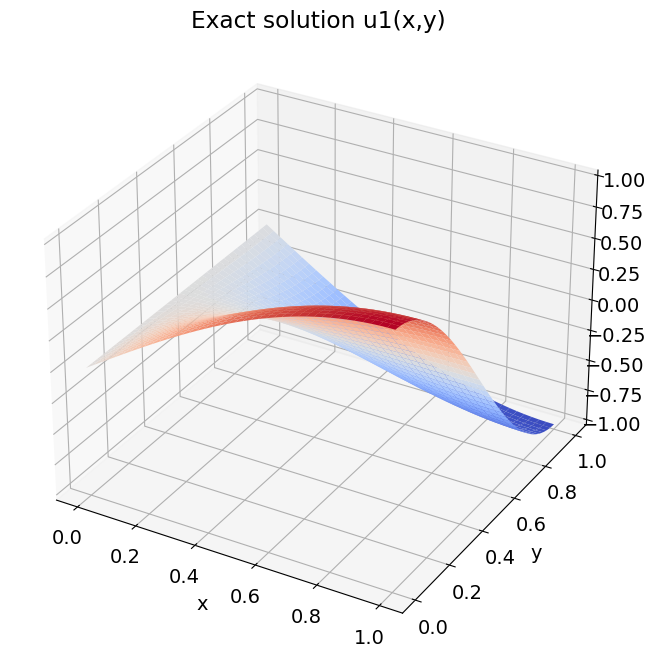

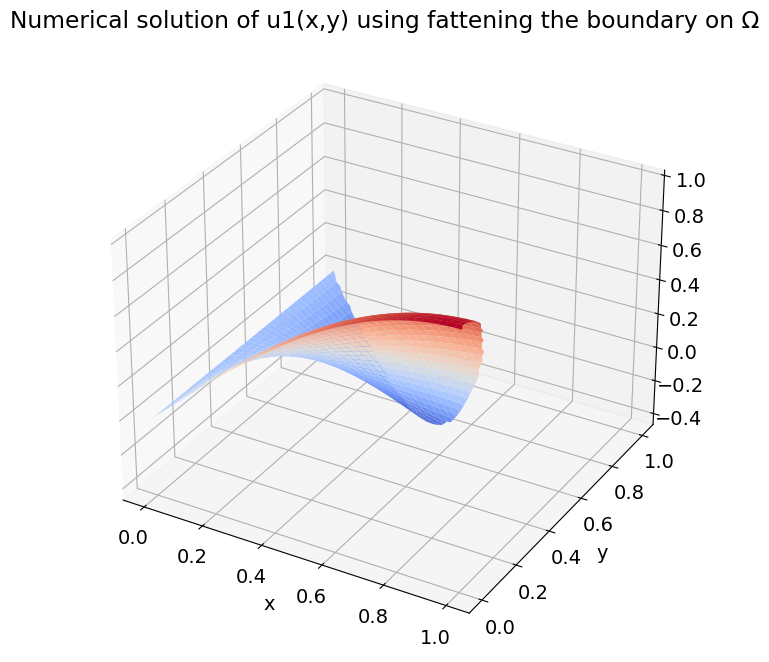

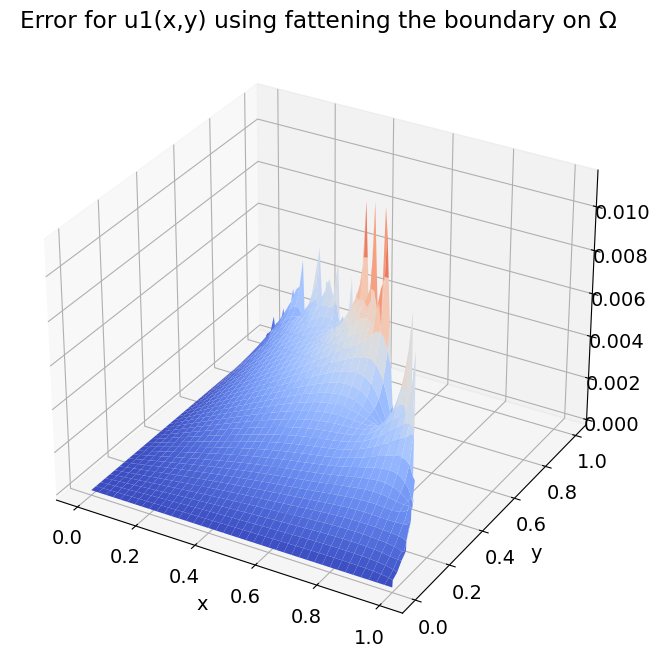

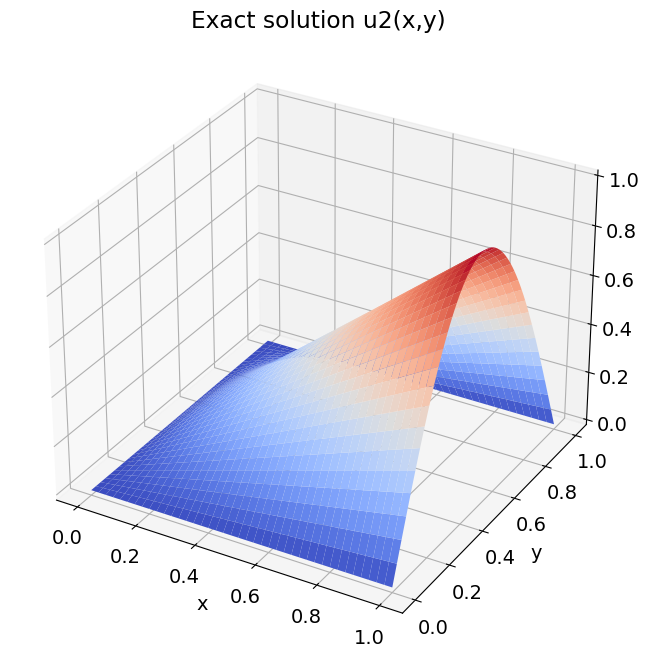

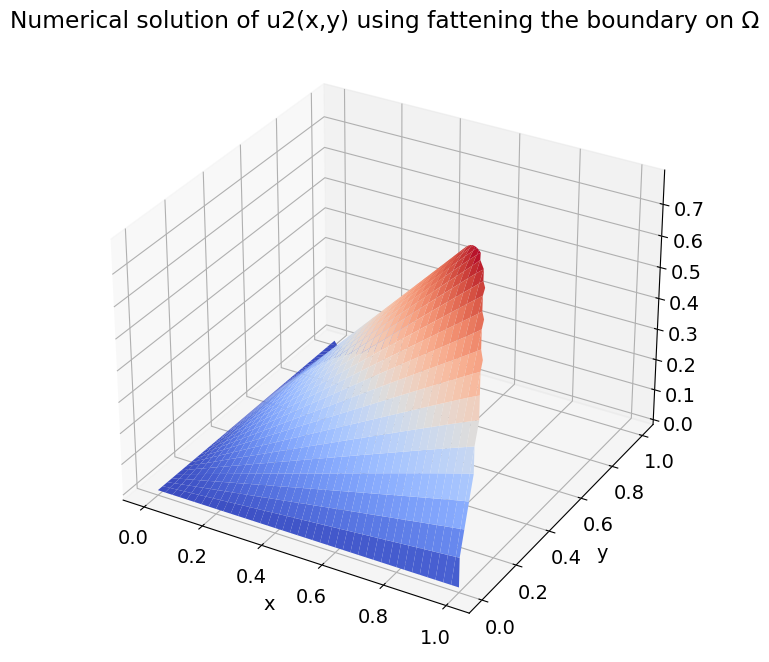

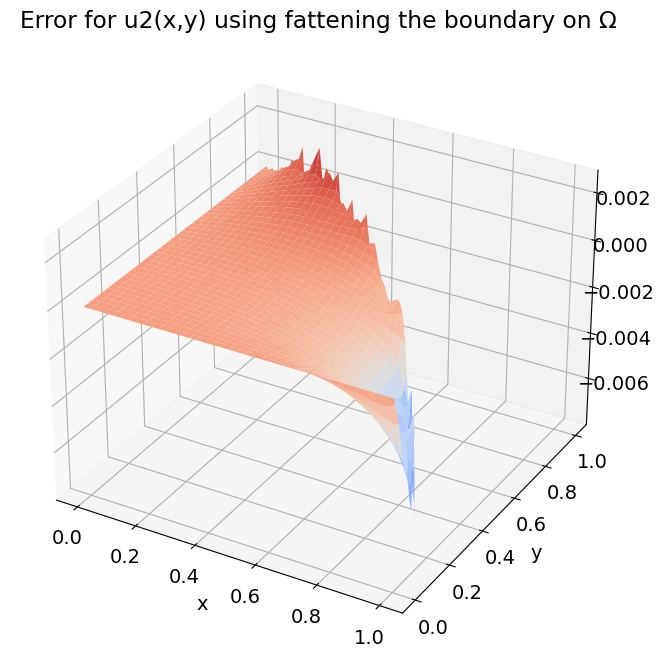

In [35]:
def u1_p(p):
    return np.cos(p[0]*np.pi)*np.sin(p[1]*np.pi/2)

def u_f1_p(p):
    return np.pi**2*np.cos(p[0]*np.pi)*np.sin(p[1]*np.pi/2)*5/4

def u2_p(p):
    return np.sin(p[0]*np.pi)*p[1]

def u_f2_p(p):
    return np.pi**2*np.sin(p[0]*np.pi)*p[1]

x, y, U = fat_b(u_f1_p, u1_p, 80)
Y,X = np.meshgrid(y,x)

plot_solution2(x,y,u1(X,Y), txt='Exact solution u1(x,y)')
plot_solution2(x,y,U,txt='Numerical solution of u1(x,y) using fattening the boundary on Ω')

plot_solution2(x,y,U-u1(X,Y), txt='Error for u1(x,y) using fattening the boundary on Ω')
plt.show()

x, y, U = fat_b(u_f2_p, u2_p,80)
Y,X = np.meshgrid(y,x)
plot_solution2(x,y,u2(X,Y),txt='Exact solution u2(x,y)')
plot_solution2(x,y,U,txt='Numerical solution of u2(x,y) using fattening the boundary on Ω')
plot_solution2(x,y,U - u2(X,Y),txt='Error for u2(x,y) using fattening the boundary on Ω')
plt.show()

0.08740787575859604
0.04001441240523418
0.024640999928320584
0.011411126408367028


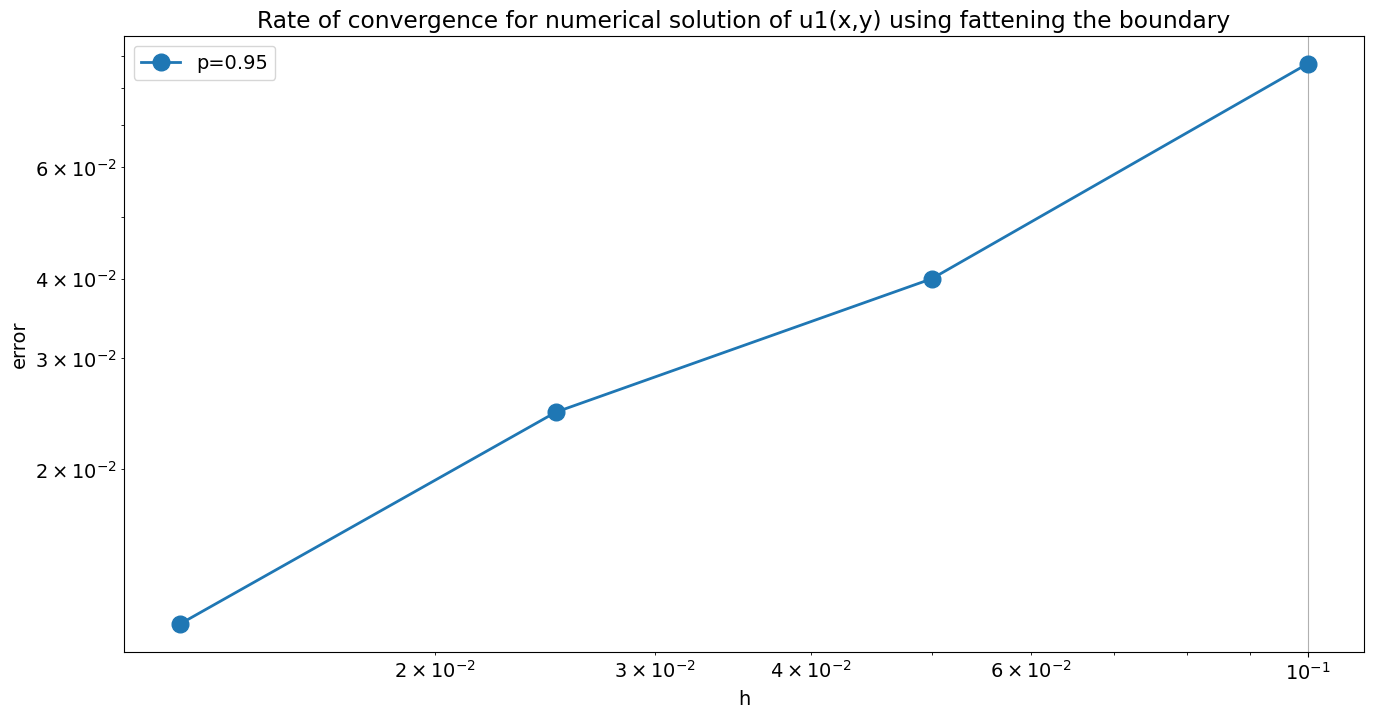

0.06614570989916824
0.030460345807975187
0.016796678837034618
0.007846418584138593


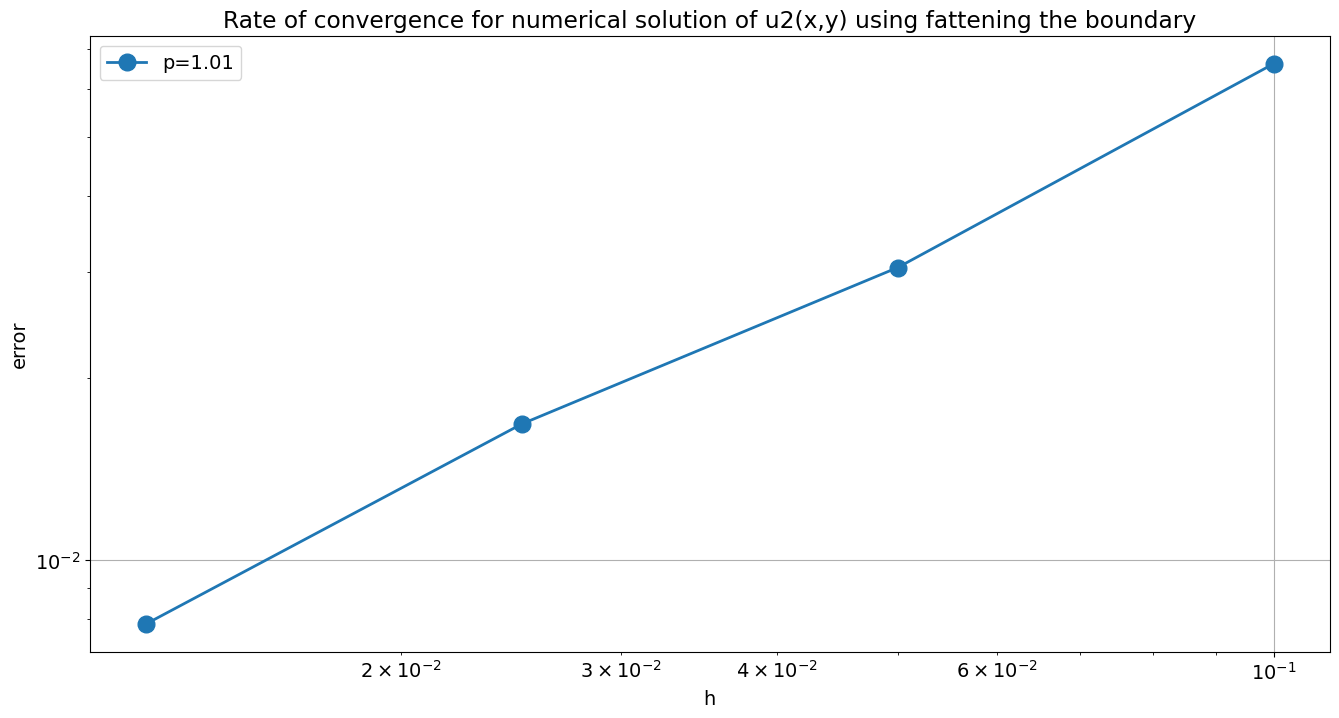

In [36]:
H, E, p = convergence2(u1, u1_p, u_f1_p, 10, fat_b)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('Rate of convergence for numerical solution of u1(x,y) using fattening the boundary')
plt.legend();
plt.show()
H, E, p = convergence2(u2, u2_p, u_f2_p, 10, fat_b)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title('Rate of convergence for numerical solution of u2(x,y) using fattening the boundary')
plt.legend();
plt.show()